# Solving Mountain Car with Semi-Gradient SARSA with polinomial feature Mapping

### Environment : Mountain Car of OpenAI Gym (MountainCar-v0)

### Description

Get an under powered car to the top of a hill (top = 0.5 position)

### States

Num | Observation  | Min  | Max  
----|--------------|------|----   
0   | position     | -1.2 | 0.6
1   | velocity     | -0.07| 0.07


### Actions

Num | Observation |
----|-------------|
0   | push left   |
1   | no push     |
2   | push right  |


### Reward

-1 for each time step, until the goal position of 0.5 is reached

### Starting State

Random position from -0.6 to -0.4 with no velocity

### Episode Termination

The episode ends when you reach 0.5 position

In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
### Modified OpenAI Gym MoutainCar environment to make maximum number of steps per episode as 500 from default 200

In [2]:
gym.envs.register(
    id='MountainCarExtraLong-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=500,
    #reward_threshold=-110.0,
)
env = gym.make('MountainCarExtraLong-v0')

[2017-04-09 21:11:37,627] Making new env: MountainCarExtraLong-v0


In [ ]:
#env = gym.make('MountainCar-v0')

In [3]:
env = gym.make('MountainCarExtraLong-v0')

[2017-04-09 21:11:40,397] Making new env: MountainCarExtraLong-v0


In [4]:
NUM_EPISODE = 800

num_actions = env.action_space.n

num_features = 8
#num_features = 5

w = np.zeros((num_actions * num_features)+1)
w[0] = 1

ALPHA = 0.01

epsilon = 0.1

GAMMA = 1

n_runs = 25

In [5]:
#polinomial features : s1, s2, s1*s2, s1^2, s2^2, s1*s2^2, s1^2*s2, s1^2*s2^2

def featureMapping(state, action):
    position = state[0]
    velocity = state[1]
    phi = [1]
    for a in range(num_actions):
        if action == a:
            #phi.extend([position, velocity, position * velocity, pow(position, 2), pow(velocity, 2), position * pow(velocity, 2), pow(position, 2) * velocity, pow(position, 2) * pow(velocity, 2)])
            #phi.extend([position, velocity, position * velocity, pow(position, 2), pow(velocity, 2)])
            phi.extend([position, velocity, position * velocity, pow(position, 2), pow(velocity, 2), position * pow(velocity, 2), pow(position, 2) * velocity, pow(position, 3) * pow(velocity, 3)])
        else:
            phi.extend([0] * num_features)
    return np.asarray(phi)

In [6]:
def approximateValueFunction(state, action, w):
    return np.dot(w, featureMapping(state, action))

In [7]:
def chooseGreedyAction(state):
    bestAction = 0
    maxQ = approximateValueFunction(state, bestAction, w)
    for action in range(num_actions):
        Q = approximateValueFunction(state, action, w)
        if Q > maxQ:
            maxQ = Q
            bestAction = action
    return bestAction

In [8]:
def chooseEpsilonGreedyAction(state, epsilon):
    explore_prob = random.uniform(0,1)
    if explore_prob >= epsilon:
        # Exploit
        action = chooseGreedyAction(state)
        #print "Greedy"
    else:
        # Explore
        action = env.action_space.sample()
        #print "Epsilon Greedy"
    return action

In [9]:
def updateWeight(state, action, target, w):
    delta_weight = ALPHA * target * featureMapping(state, action)
    weight = w + delta_weight
    return weight

#### Semi-Gradient SARSA with Polinomial Feature Mapping

In [10]:
episode_lengths_all_runs = np.zeros((NUM_EPISODE, n_runs))
episode_rewards_all_runs = np.zeros((NUM_EPISODE, n_runs))

for k in range(n_runs):

    episode_length = np.zeros(NUM_EPISODE)
    episode_reward = np.zeros(NUM_EPISODE)
    w = np.zeros((num_actions * num_features) + 1)
    w[0] = 1

    for i in range(NUM_EPISODE):
        #Initialize S,A
        state = env.reset()
        action = env.action_space.sample()
        length = 1

        #For each step of episode
        while True:
            if state[0] >= 0.5:
                print("Episode = {}, step = {}, Position ={}".format(i, length, state[0]))
                print "Goal state reached"
            #Take action A, observe R, S'
            nextState, reward, done, info = env.step(action)
            #Choose A' from S' (epsilon greedily)
            nextAction = chooseEpsilonGreedyAction(nextState, epsilon)
            delta = reward + GAMMA * approximateValueFunction(nextState, nextAction, w) - approximateValueFunction(state, action, w)
            w = updateWeight(state, action, delta, w)
            #print w
            length += 1
            episode_reward[i] += reward

            state = nextState
            action = nextAction
            if done == True:
                episode_length[i] = length
                episode_rewards_all_runs[:,k] = episode_reward
                episode_lengths_all_runs[:, k] = episode_length
                #print "End of Episode"
                break

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


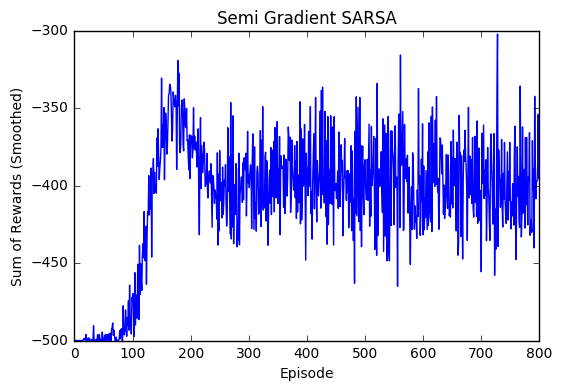

In [11]:
avg_reward_SG = np.mean(episode_rewards_all_runs, axis=1)

plt.plot(np.arange(NUM_EPISODE), avg_reward_SG)
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards (Smoothed)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Semi Gradient SARSA')
plt.show()

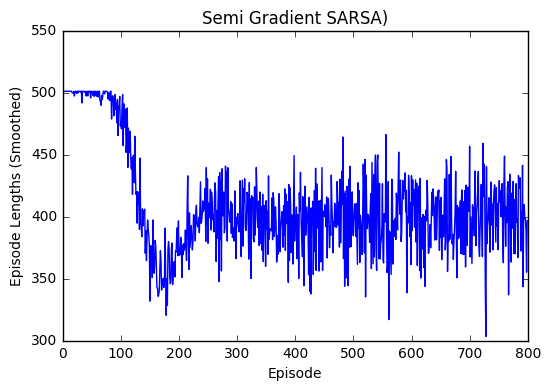

In [12]:
avg_episode_length_SG = np.mean(episode_lengths_all_runs, axis=1)

plt.plot(np.arange(NUM_EPISODE), avg_episode_length_SG)
plt.xlabel('Episode')
plt.ylabel('Episode Lengths (Smoothed)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Semi Gradient SARSA)')
plt.show()

### Discussion :

* Polinomial feature mapping does not work good for this problem. As per literature, tile coding, Radial Basis Function promise to be better
* Volatility in the accumulated reward is due to approximation error

#### References:
1. https://github.com/openai/gym/wiki/MountainCar-v0